In [250]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style('whitegrid')

import re

from scipy.stats import ttest_ind
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, roc_auc_score, plot_roc_curve,
                            roc_curve, auc)

def preprocess(texts):
    #function takes as an input iterable of 
    plain_text = []
    for review in texts:
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = review.lower().split()

        review = ' '.join(review)
        plain_text.append(review)
        
    return plain_text

def get_n_highest_scores(n, vectorizer, tfidf_result, verbose=0):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

    highest_scores = {}
    for index, item in enumerate(sorted_scores):
        highest_scores[item[0]] = round(item[1],2)
        
        if verbose == 1:
            print("{0:50} Score: {1}".format(item[0], round(item[1],2)), index)
        
        if index == n:
            break
    
    return highest_scores

def count_avg_word_len(review):
    return np.mean([len(word) for word in review.split()])

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def dense_ndarray_to_sparse_tensor(arr):
    idx  = np.where(arr != 0.0)
    return tf.SparseTensor(np.vstack(idx).T, arr[idx], arr.shape)

def get_predictions(models):
    train_preds = {}
    for model in models:
        train_preds[model.__class__.__name__] = model.predict(X_train)

    test_preds = {}
    for model in models:
        test_preds[model.__class__.__name__] = model.predict(X_test)

    return train_preds, test_preds


def append_to_results(results_df, train_preds, test_preds, metrics):
    models = list(train_preds.keys())

    for metric in metrics:

        for model in models:
            test_accuracy = metric(y_test, test_preds[model])
            train_accuracy = metric(y_train, train_preds[model])

            to_append = pd.DataFrame(columns=list(results_df.columns),
                            data=np.array([model, metric.__name__, round(test_accuracy,2),
                                               round(train_accuracy,2)]).reshape(1, -1))

            results_df = results_df.append(to_append)

    results_df = results_df.astype({
        'TrainPrediction': float,
        'TestPrediction': float
    })

    results_df.replace('Sequential', 'NeuralNetwork')
    pivot = results_df.pivot_table(index='Algorithm', columns='Metric', values=['TestPrediction','TrainPrediction'])
    
    return pivot
        
df = pd.read_csv('sentiment_movies.csv', sep=',', encoding='latin1', engine='python', quotechar='"')
df.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [268]:
lemmatizer = WordNetLemmatizer()
reviews = df['SentimentText'].to_numpy()

X = preprocess(reviews)

tfidf = TfidfVectorizer(stop_words='english', min_df=0.2, max_df=1.0)
X = tfidf.fit_transform(X)
y = df['Sentiment'].to_numpy()

first1000 = get_n_highest_scores(1000, tfidf, X)

df['WordCount'] = df['SentimentText'].apply(lambda x: len(x.split()))

df['AvgWordLength'] = df['SentimentText'].apply(count_avg_word_len)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Positive word length variance 0.22589102543219527

Negative word length variance 0.20097335436383815

 Ttest_indResult(statistic=13.326867837343025, pvalue=2.219051295839987e-40)

Variables do not have different means


<AxesSubplot:xlabel='Review sentiment', ylabel='Average word length'>

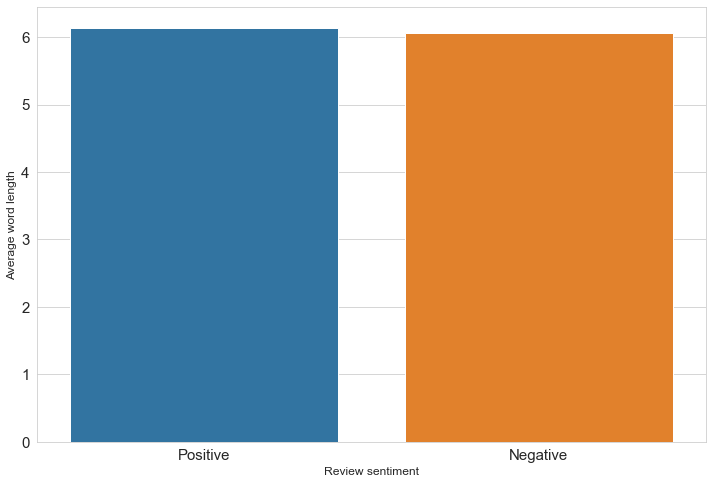

In [202]:
positive_avg_len = df[df['Sentiment'] == 1]['AvgWordLength']
negative_avg_len = df[df['Sentiment'] == 0]['AvgWordLength']

print('Positive word length variance', np.var(positive_avg_len))
print('\nNegative word length variance', np.var(negative_avg_len))

print('\n',ttest_ind(positive_avg_len, negative_avg_len))

print('\nVariables do not have different means')

means = [np.mean(positive_avg_len), np.mean(negative_avg_len)]
plt.figure(figsize=(12,8))

plt.xlabel('Review sentiment', fontsize=12)
plt.xticks(fontsize=15)

plt.ylabel('Average word length', fontsize=12)
plt.yticks(fontsize=15)
sns.barplot(x=['Positive', 'Negative'], y=means)

In [203]:
first10 = get_n_highest_scores(10, tfidf, X)
first10

{'br': 9800.25,
 'movie': 5689.11,
 'film': 5285.14,
 'like': 2933.52,
 'good': 2525.23,
 'time': 2230.59,
 'story': 2197.21,
 'really': 2055.65,
 'great': 1894.48,
 'bad': 1786.39,
 'people': 1751.94}

In [204]:
log_reg = LogisticRegression().fit(X_train, y_train)
n_bayes = MultinomialNB().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

In [205]:
tensor_X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
tensor_X_train = tf.sparse.reorder(tensor_X_train)
dense_X_train = tf.sparse.to_dense(tensor_X_train)

tensor_y_train = dense_ndarray_to_sparse_tensor(y_train)
tensor_y_train = tf.sparse.reorder(tensor_y_train)
dense_y_train = tf.sparse.to_dense(tensor_y_train)

tensor_X_test = convert_sparse_matrix_to_sparse_tensor(X_test)
tensor_X_test = tf.sparse.reorder(tensor_X_test)

n_network = keras.Sequential()

n_network.add(keras.layers.Dense(8, activation='relu'))
n_network.add(keras.layers.Dense(6, activation='relu'))
n_network.add(keras.layers.Dense(1, activation='sigmoid'))

n_network.compile(optimizer='Adam', loss='binary_crossentropy', metrics='accuracy')

In [206]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
callbacks = [early_stopping_callback]

n_network.fit(dense_X_train, dense_y_train, epochs=10, batch_size=16, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
938/938 [==============================] - 9s 5ms/step - loss: 0.6702 - accuracy: 0.5687 - val_loss: 0.6104 - val_accuracy: 0.6549
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.6132 - accuracy: 0.6626 - val_loss: 0.6055 - val_accuracy: 0.6643
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.6097 - accuracy: 0.6671 - val_loss: 0.6084 - val_accuracy: 0.6515
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.6144 - accuracy: 0.6617 - val_loss: 0.6027 - val_accuracy: 0.6653
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.6065 - accuracy: 0.6653 - val_loss: 0.6041 - val_accuracy: 0.6627
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.6067 - accuracy: 0.6699 - val_loss: 0.6038 - val_accuracy: 0.6667
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.6056 - accuracy: 0.6700 - val_loss: 0.6036 - val_accuracy: 0.6611
Epoch 

In [207]:
algorithms = [log_reg, n_bayes, knn]
train_preds, test_preds = get_predictions(algorithms)

network_test_preds = n_network.predict_classes(tensor_X_test)
network_train_preds = n_network.predict_classes(tensor_X_train)

train_preds['NeuralNetwork'] = network_train_preds
test_preds['NeuralNetwork'] = network_test_preds

results_df = pd.DataFrame(columns=['Algorithm','Metric','TrainPrediction','TestPrediction'])

metrics = [accuracy_score, precision_score, recall_score, roc_auc_score]
results = append_to_results(results_df, train_preds, test_preds, metrics)
results

C:\Users\partycy\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TestPrediction                               \
Metric               accuracy_score precision_score recall_score   
Algorithm                                                          
KNeighborsClassifier           0.74            0.72         0.76   
LogisticRegression             0.67            0.65         0.70   
MultinomialNB                  0.66            0.65         0.68   
NeuralNetwork                  0.65            0.68         0.56   

                                   TrainPrediction                  \
Metric               roc_auc_score  accuracy_score precision_score   
Algorithm                                                            
KNeighborsClassifier          0.74            0.61            0.61   
LogisticRegression            0.67            0.67            0.67   
MultinomialNB                 0.66            0.67            0.67   
NeuralNetwork                 0.65            0.65            0.70   

                                                 
Metric               recall_score roc_auc_score  
Algorithm                                        
KNeighborsClassifier         0.62          0.61  
LogisticRegression           0.70          0.67  
MultinomialNB                0.68          0.67  
NeuralNetwork                0.56          0.66

No handles with labels found to put in legend.
C:\Users\partycy\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


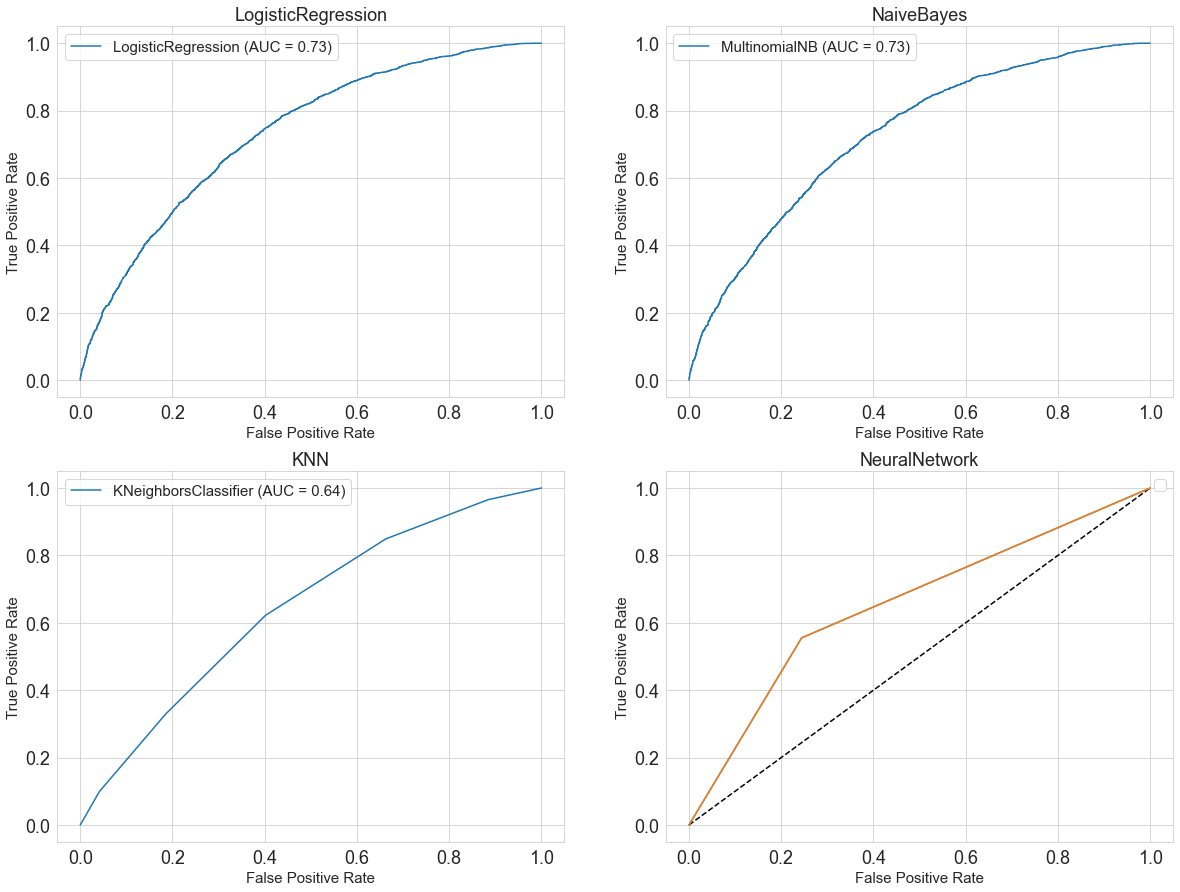

In [208]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
# matplotlib.rc('xlabel', fontsize=18) 

axes[0][0].set_title('LogisticRegression', fontsize=18)
axes[0][1].set_title('NaiveBayes', fontsize=18)
axes[1][0].set_title('KNN', fontsize=18)
axes[1][1].set_title('NeuralNetwork', fontsize=18)

axes[0][0].set_xlabel('False Positive Rate', fontsize=15)
axes[0][1].set_xlabel('False Positive Rate', fontsize=15)
axes[1][0].set_xlabel('False Positive Rate', fontsize=15)
axes[1][1].set_xlabel('False Positive Rate', fontsize=15)

axes[0][0].set_ylabel('True Positive Rate', fontsize=15)
axes[0][1].set_ylabel('True Positive Rate', fontsize=15)
axes[1][0].set_ylabel('True Positive Rate', fontsize=15)
axes[1][1].set_ylabel('True Positive Rate', fontsize=15)

plot_roc_curve(log_reg, X_test, y_test, ax=axes[0][0])
plot_roc_curve(n_bayes, X_test, y_test, ax=axes[0][1])
plot_roc_curve(knn, X_test, y_test, ax=axes[1][0])
# plot_roc_curve(n_network, X_test, y_test, ax=axes[1][1])

axes[0][0].legend(fontsize=15)
axes[0][1].legend(fontsize=15)
axes[1][0].legend(fontsize=15)
axes[1][1].legend(fontsize=15)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, network_test_preds)
auc_keras = auc(fpr_keras, tpr_keras)

y_pred_rf = n_network.predict_proba(tensor_X_test)#[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, network_test_preds)
auc_rf = auc(fpr_rf, tpr_rf)
axes[1][1].plot([0, 1], [0, 1], 'k--')
axes[1][1].plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
axes[1][1].plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))

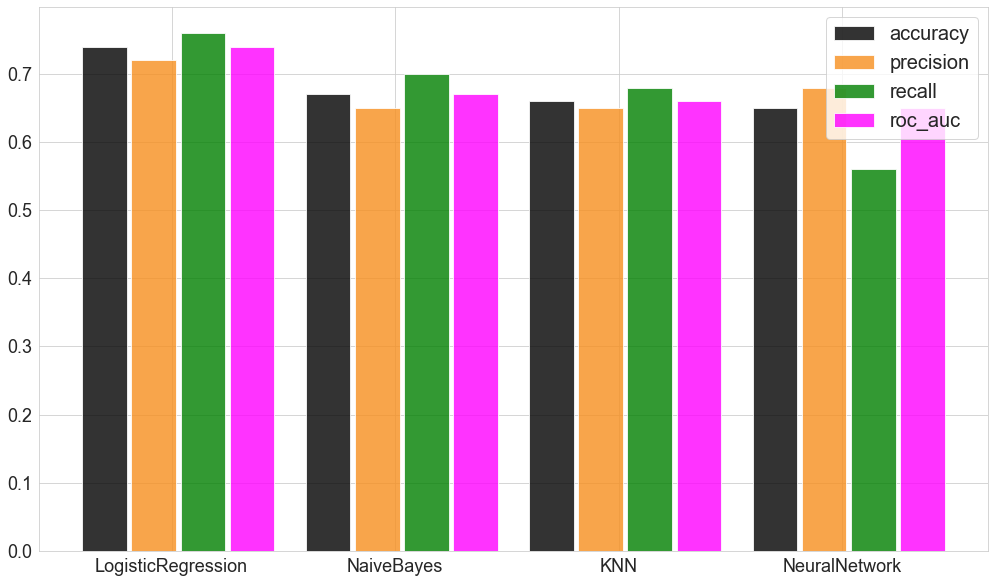

In [209]:
fig, axes = plt.subplots(figsize=(17,10))

xlabels = ['LogisticRegression', 'NaiveBayes', 'KNN', 'NeuralNetwork']

pos = list(range(len(xlabels)))

x = np.arange(len(xlabels))  
width = 0.2
axes.set_xlabel = xlabels

axes.bar(pos, results['TestPrediction']['accuracy_score'], 
        width, alpha=0.8,color='black') 

axes.bar([p + width + 0.02 for p in pos], results['TestPrediction']['precision_score'], 
        width, alpha=0.8,color='#F78F1E', label='recall') 

axes.bar([p + width*2 + 0.04 for p in pos], results['TestPrediction']['recall_score'], 
        width, alpha=0.8,color='green', label='recall') 

axes.bar([p + width*3 + 0.06 for p in pos], results['TestPrediction']['roc_auc_score'],
        width, alpha=0.8,color='#FF00FF', label='recall') 

plt.xticks(x + 0.3 ,xlabels)

plt.legend(['accuracy','precision','recall','roc_auc'], fontsize=20)